# Dip picking

__student__ Imane SI SALAH (MVA)

### We suppose that the well has a diameter of 8.5 inches

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import math
R=8.5 #in inchees

## Parameters

In [2]:
absent_value = -9999.0

## Data Loading

In [3]:
imageInput = np.load('FMI_STAT_5010_5110.npy')
num_rows_total, num_columns_total = imageInput.shape
tdep = np.load('TDEP_5010_5110.npy') #use this to get z 

### Visualization

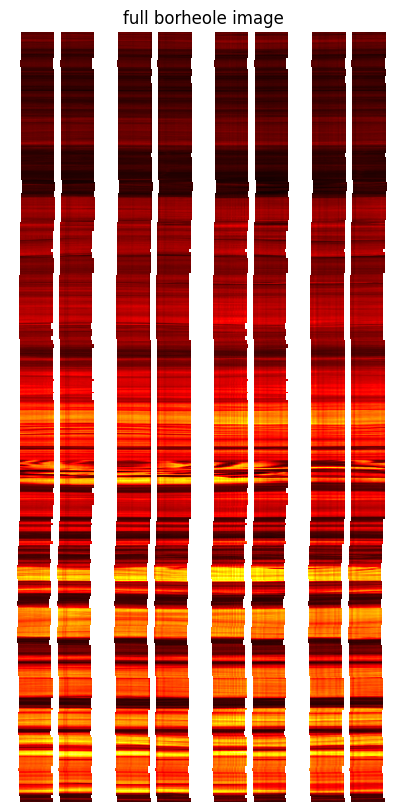

-9999.0


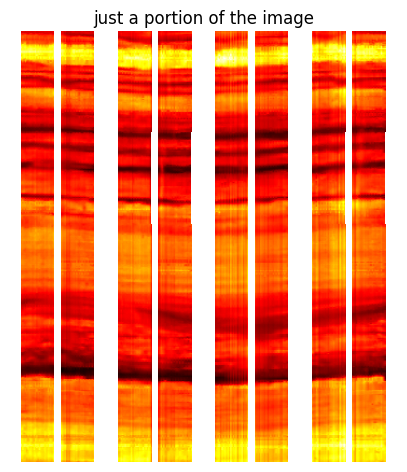

-9999.0


In [4]:
imageDisplay = np.copy(imageInput)
mask_absent = (imageInput == absent_value)
imageDisplay[mask_absent] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(5, 10))
ax.imshow(imageDisplay, 'hot', aspect='auto')
plt.title('full borheole image')
plt.axis('off')
plt.show()
print(np.min(imageInput.flatten()))

start = 600
end = 1000
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
ax.imshow(imageDisplay[start:end, :], 'hot')
plt.title('just a portion of the image')
plt.axis('off')
plt.show()
print(np.min(imageInput.flatten()))

throughout the lab work we will be using a small portion of the image to illustrate the results instead of the full image for better visualization of the sinusoid

In [5]:
start = 600
end = 1000
img = np.copy(imageDisplay[start:end, :])  #slicing a part of the image 
depth= np.copy(tdep[start:end])

## Sinusoid extraction: automated trend extraction using randomized hough transform
Implement randomized Hough transform:
-  Compute gradient of image and associated vectors
-  Display the vectors
-  Pick randomly vectors and compute their vectorial product; store them in an accumulator
-  Take the most probable vector
-  Compute the associated angles
-  Display the associated sinusoid

## 1. Define helper functions

In this section we define all helper functions we'll use later on in oder to implement the hugh transform as desribed in the previous steps:

In [52]:
def grad_2D(img):
    """
    compute the gradient of the image in 2D along the x and y axis
    """
    gX = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=1, dy=0)  # Gradient in X direction
    gY = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=0, dy=1)  # Gradient in Y direction
    return (gX, gY)

def xyz_from_image(point,depth=None, image_dims= img.shape):
    """
    get the coordinates of the any point (x,y)
    in the image in the borehole cylinder with x,y,z
    we consider that the length of x makes a closed loop on azimuth angles
    """
    #get R from the image width  
    x_2D,y_2D= point
    circomf= image_dims[1]
    theta= (x_2D/ circomf)*2*np.pi
    x= R*np.cos(theta)
    y= R*np.sin(theta)
    if depth is not None:
        alt= depth[y_2D+start]* 12
        z= alt  
    else :
        z=0. #given in tdep
    return np.array([x,y,z])

def sinusoid_from_angles(phi, alpha, delta, R=1):
    """
    once we have the estimated values for the angles alpha and delta we retreive
    sinusoid using this function.
    """
    Z0= np.cos(delta) 
    Z= Z0+ R*np.tan(delta)*np.cos(phi - alpha)
    return Z

def cross_prod_to_angles(normal_vector): 
    """
    Converts a normal vector of a plane in 3D to azimuth and inclination angles.
    """
    # normalize the vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    x,y,z= normal_vector
    if z<0: # take - p instead of p if p is negative
        x,y,z=-x,-y,-z
    # Inclination (delta) is the angle between the normal vector and the z-axis
    delta = np.arccos(z)
    # Azimuth (alpha) is the angle between the projection of the normal vector on the x-y plane and the x-axis
    alpha = np.arctan2(y, x)
    return alpha, delta

def grad2D_to_3D(point, grad, depth=None):
    """
    go from the 2D gradient vector (supposedly perpondicular to the sinusoid in the  image)
    to the 3D tangential gradient at a given point(x,y)
    """
    x,y= point
    gX,gY= grad
    angle= np.pi/2
    rotated_gx= gX*np.cos(angle) - gY* np.sin(angle)
    rotated_gy= gX*np.sin(angle) + gY* np.cos(angle)
    rotated_gx= rotated_gx/np.max(rotated_gx)
    rotated_gy= rotated_gy/np.max(rotated_gy)
    M= np.array([x,y])
    M_prime= np.array([int(x+ rotated_gx), int(y+ rotated_gy)]) if not np.isnan(x+ rotated_gx +y+ rotated_gy ) else np.zeros_like(M)

    M_3D= xyz_from_image(M, depth)
    M_prime_3D= xyz_from_image(M_prime, depth)

    vec_3D= M_prime_3D - M_3D

    return vec_3D

Test the __cross_prod_to_angles()__ function, taking a normal with coordinates [1,1,1] and visualize the retreved plane from the azimuth and inclination angles

Normal vector: [1 1 1]
Azimuth (alpha): 45.0 degrees
Inclination (delta): 54.735610317245346 degrees


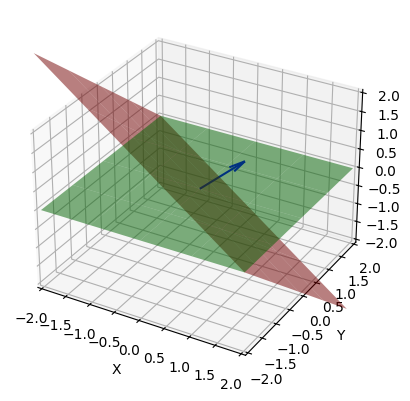

In [53]:
# Test the function with a normal vector
normal_vector = np.array([1, 1, 1])  # Example vector
alpha, delta = cross_prod_to_angles(normal_vector)
print(f"Normal vector: {normal_vector}")
print(f"Azimuth (alpha): {np.degrees(alpha)} degrees")
print(f"Inclination (delta): {np.degrees(delta)} degrees")

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the normal vector
ax.quiver(0, 0, 0, normal_vector[0], normal_vector[1], normal_vector[2], color='b', length=1.0, normalize=True)

# Plane P' (the input plane)
point = np.array([0, 0, 0])  # A point on the plane P'
d = -point.dot(normal_vector)  # Plane equation: ax + by + cz + d = 0
xx, yy = np.meshgrid(range(-2, 3), range(-2, 3))
zz = (-normal_vector[0] * xx - normal_vector[1] * yy - d) * 1. / normal_vector[2]

ax.plot_surface(xx, yy, zz, color='r', alpha=0.5)

# Horizontal plane for reference
zz_hor = np.zeros_like(zz)
ax.plot_surface(xx, yy, zz_hor, color='g', alpha=0.5)

# Setting the axes properties
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

To check if the fucntions work correctly, try to implement the fullprocess on a pair of points:


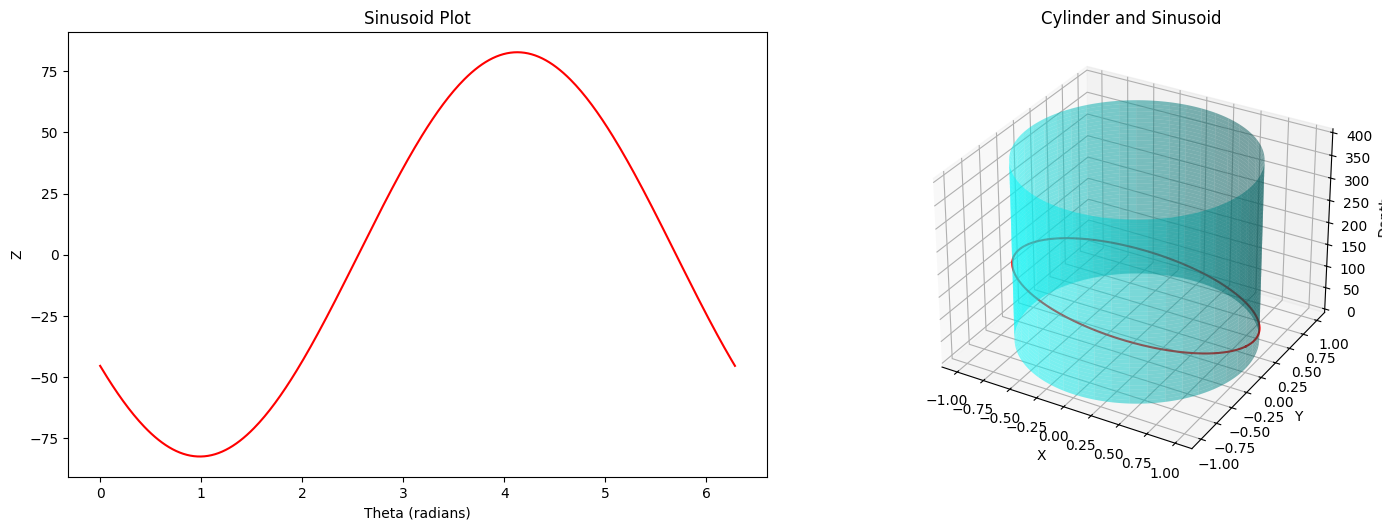

In [59]:
gX, gY = grad_2D(img)
magnitudes = np.sqrt(gX**2 + gY**2)

# Random points and operation
point1 = np.array([np.random.randint(0, img.shape[1]), np.random.randint(0, img.shape[0])])
point2 = np.array([np.random.randint(0, img.shape[1]), np.random.randint(0, img.shape[0])])
grad1 = np.array([gX[point1[1], point1[0]], gY[point1[1], point1[0]]])
grad2 = np.array([gX[point2[1], point2[0]], gY[point2[1], point2[0]]])

# 3D vectors
vec3D1 = grad2D_to_3D(point1, grad1, tdep)
vec3D2 = grad2D_to_3D(point2, grad2, tdep)

# Compute cross product and retrieve angles
normal = np.cross(vec3D1, vec3D2)
azimuth, inclination = cross_prod_to_angles(normal)

# Get the sinusoid from angles
theta_grid = np.linspace(0, 2 * np.pi, 360)
Z = sinusoid_from_angles(theta_grid, azimuth, inclination, R=8.5)


fig = plt.figure(figsize=(15, 10))

# Sinusoid plot
ax0 = fig.add_subplot(221)
ax0.plot(theta_grid, Z, 'r-')
ax0.set_title('Sinusoid Plot')
ax0.set_xlabel('Theta (radians)')
ax0.set_ylabel('Z')

# Cylinder and ellipse
ax1 = fig.add_subplot(222, projection='3d')
z_grid = np.linspace(0, img.shape[0], 50)
theta_grid_c, z_grid_c = np.meshgrid(theta_grid, z_grid)
x_grid_c = np.cos(theta_grid_c)
y_grid_c = np.sin(theta_grid_c)
Z_3D = sinusoid_from_angles(theta_grid, azimuth, inclination, R=8.5) + point1[0]
ax1.plot_surface(x_grid_c, y_grid_c, z_grid_c, color='cyan', alpha=0.5, linewidth=0)
ax1.plot(np.cos(theta_grid), np.sin(theta_grid), Z_3D, color='red')
ax1.set_title('Cylinder and Sinusoid')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Depth')

plt.tight_layout()
plt.show()

## 2. Compute and Diplay 2D gradient vectors

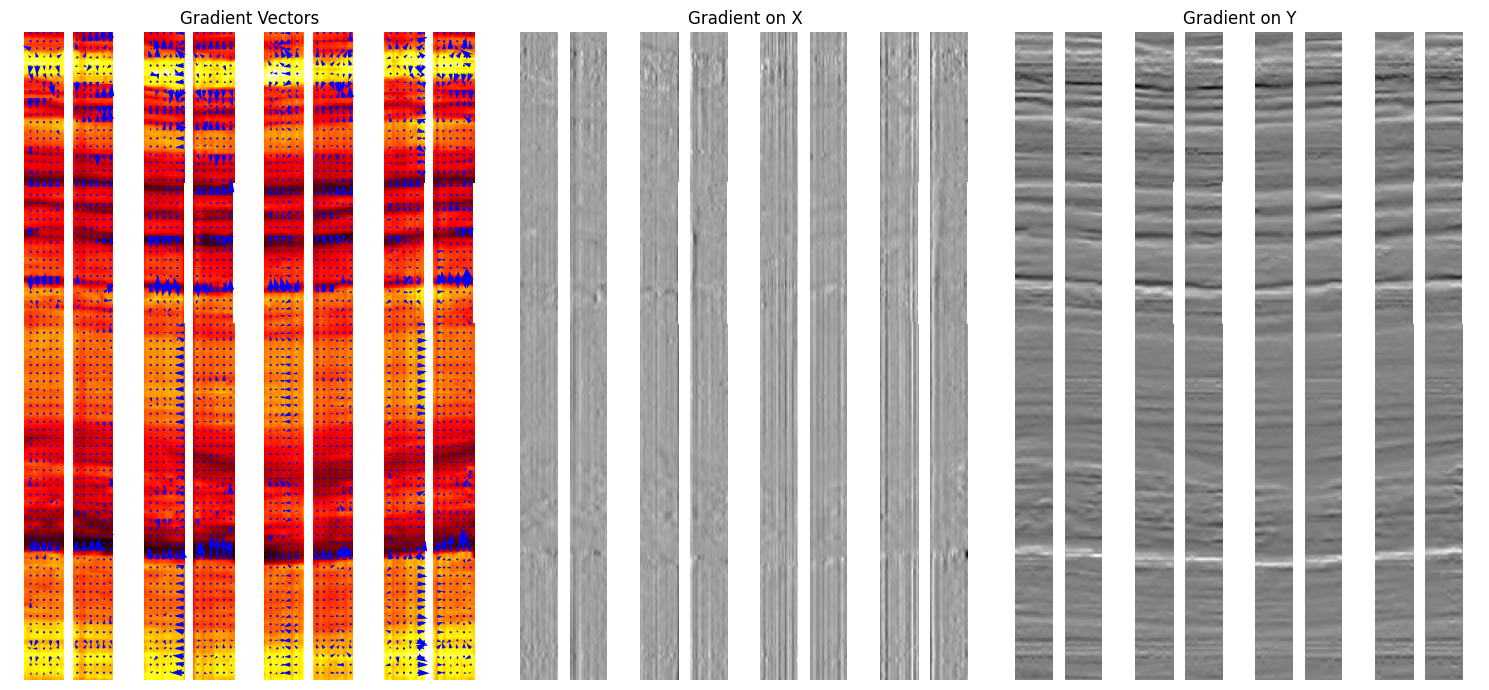

In [60]:
gX,gY= grad_2D(img)

#sampling step to reduce the number of vectors to display
step = 5

# Sample the gradients
gX_steps = gX[::step, ::step]
gY_steps = gY[::step, ::step]

# Create a meshgrid of coordinates (x, y) for the quiver plot
x, y = np.meshgrid(np.arange(0, img.shape[1], step), np.arange(0, img.shape[0], step))

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot the image and gradient vectors
axs[0].imshow(img, cmap='hot', aspect='auto')
axs[0].quiver(x, y, gX_steps, gY_steps, color='blue', width=0.005)
axs[0].set_title('Gradient Vectors')
axs[0].axis('off')

# Plot the gradient on X
axs[1].imshow(gX, cmap='gray', aspect='auto')
axs[1].set_title('Gradient on X')
axs[1].axis('off')

# Plot the gradient on Y
axs[2].imshow(gY, cmap='gray', aspect='auto')
axs[2].set_title('Gradient on Y')
axs[2].axis('off')

plt.tight_layout()
plt.show()


We can see that most of the gradient vectors are directed upward or downward following the contrast changes in the image.

Then we investigate the histogram of gradients in order to select only points within a relevant  gradient range for later on steps:

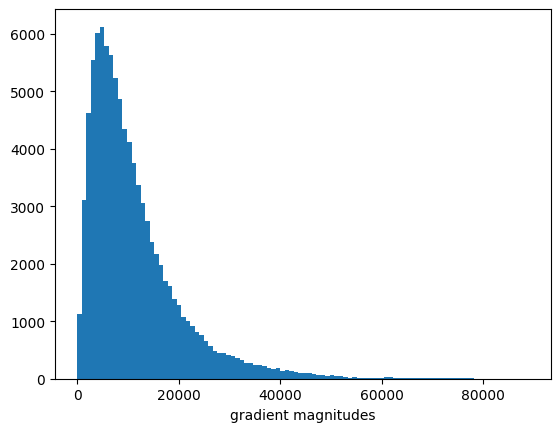

In [61]:
#get magintudes historgram 
magnitudes = np.sqrt(gX**2 + gY**2)
magnitude_f = magnitudes[~np.isnan(magnitudes)].flatten()

# Plot histogram directly
plt.hist(magnitude_f, bins=100)
plt.xlabel('gradient magnitudes')
plt.show()

We see from the histogram that most of the pixels have values of gradient magnitudes in the range [500, 2000], so we only pick gradients within this range

In [62]:
#create a two lists containing selected gradients and their coordinates
min_thresh = 500  #minimum threshold
max_thresh = 2000 #maximum threshold
selected_indices = np.where((magnitudes >= min_thresh) & (magnitudes <= max_thresh))
selected_gradients = magnitudes[selected_indices]
selected_coordinates = np.array(selected_indices).T  # (y,x) coordinate pairs


## 3. Fill in the accumulator

we proceed to fill the acumulator that is a 2D array representifn azimuth and inclination angles:

for this we follow the steps:

- retreive the list of points to use from the gradient selection
- iterate throug all possible combinations of 2 of these points 
- get the pair 3D tangent vectors at each selected point:
    - for this first get the 2D gradients 
    - then apply the __grad2D_to_3D()__ to get the 3d reprensetation
- compte the cross product (which will represent the normal of the plane containing the two vectors)
- get the azimuth and inclination angle from this normal
- increment the accumulator 

In [98]:
import numpy as np
from itertools import combinations
import random
random.seed(0)


num_points = len(selected_coordinates)
sample_size = min(num_points, 1000)  


if num_points > sample_size:
    sampled_indices = random.sample(range(num_points), sample_size)
    points_to_use = selected_coordinates[sampled_indices]
else:
    points_to_use = selected_coordinates


points_to_use = [tuple(point) for point in points_to_use]

# Initialize the accumulator
accumulator = np.zeros((90, 360))
best_pair = np.zeros((1, 2))
best_norm = 0  

# Iterate over combinations of points
for point1, point2 in combinations(points_to_use, 2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    if point2[0] == 360:
        continue
    # print('point1', point1)
    # print('point2', point2)


    # get gradients for these points
    grad1 = np.array([gX[point1[0], point1[1]], gY[point1[0], point1[1]]])
    grad2 = np.array([gX[point2[0], point2[1]], gY[point2[0], point2[1]]])

    vec3D1 = grad2D_to_3D(point1, grad1, tdep) #returned coordinates in inches
    vec3D2 = grad2D_to_3D(point2, grad2, tdep)
    normal = np.cross(vec3D1, vec3D2) # logiquement x,y,z are in inches
    azimuth, inclination = cross_prod_to_angles(normal)

    # Update the accumulator based on conditions
    if not np.isnan(np.rad2deg(azimuth)) and not np.isnan(np.rad2deg(inclination)):
        norm = np.linalg.norm(normal)
        if norm > best_norm: 
            accumulator[int(np.rad2deg(inclination)) - 1, int(np.rad2deg(azimuth)) - 1] += norm
            best_norm = norm
            best_pair = np.unravel_index(np.argmax(accumulator), accumulator.shape)
            pts = [point1, point2]


C:\Users\imane\AppData\Local\Temp\ipykernel_43136\1934942351.py:42: RuntimeWarning: invalid value encountered in divide
  normal_vector = normal_vector / np.linalg.norm(normal_vector)


Now display this accumulator:

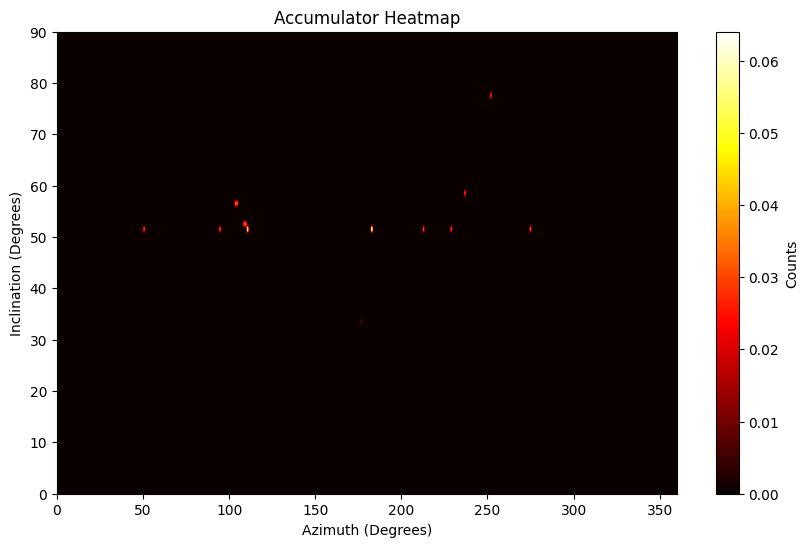

In [99]:
plt.figure(figsize=(10, 6))  
plt.imshow(accumulator, aspect='auto', cmap='hot', origin='lower',
           extent=[0, 360, 0, 90])  
plt.colorbar(label='Counts')  
plt.xlabel('Azimuth (Degrees)')
plt.ylabel('Inclination (Degrees)')
plt.title('Accumulator Heatmap')
plt.show()

We can distinguish few points on the accumulator that will represent the modes of our sinusoinds. an important property we can see is that all the sinusoids will have approximatly the same inclinations it means they will be parallel, which makes senes given the image we have, no sinusoids cross with each other

In [14]:
vertical_step= imageInput.shape[0]

Coordinates of the 10 successive maximums: [(51, 182), (51, 110), (51, 94), (51, 212)]


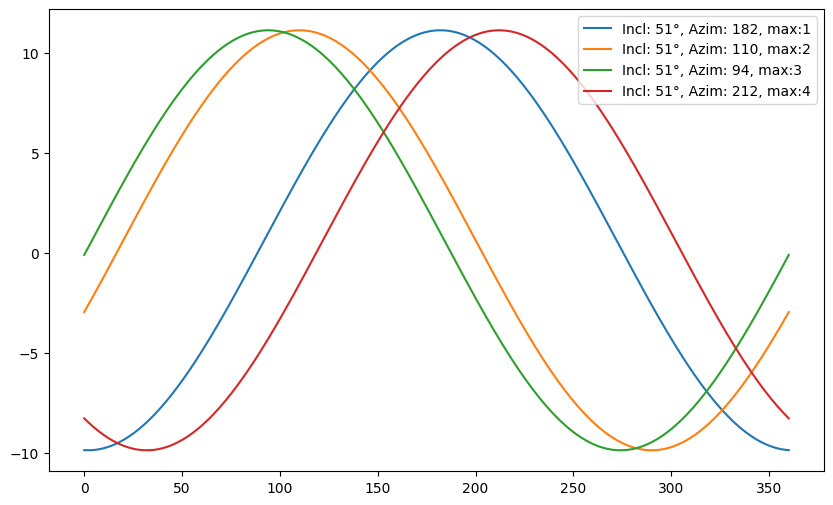

In [77]:
# Find the coordinates of the 10 successive maximums
acc=np.copy(accumulator)
max_coords = []
for _ in range(4):
    max_index = np.unravel_index(np.argmax(acc), acc.shape)
    max_coords.append(max_index)
    # Set the maximum value to -inf so it's not considered again
    acc[max_index] = -np.inf

print("Coordinates of the 10 successive maximums:", max_coords)

#plot
theta_grid = np.linspace(0, 2 * np.pi, img.shape[1])
plt.figure(figsize=(10, 6))
i=1
for inclination_idx, azimuth_idx in max_coords:
    inclination = np.deg2rad(inclination_idx)  # Convert index to radians
    azimuth = np.deg2rad(azimuth_idx)  # Convert index to radians
    Z = sinusoid_from_angles(theta_grid, azimuth, inclination, R=8.5) #I need to go back to the pixel space 
    plt.plot(np.rad2deg(theta_grid), Z, label=f'Incl: {inclination_idx}°, Azim: {azimuth_idx}, max:{i}')
    i+=1
plt.legend()
#now the z values are being retreived in inches

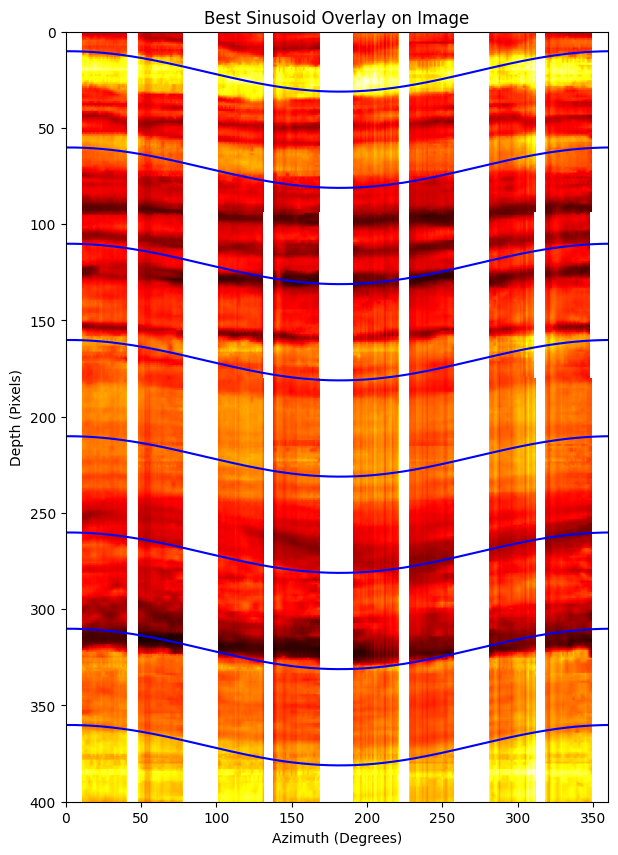

In [78]:
max_index = max_coords[0]
inclination, azimuth = np.deg2rad(max_index)  # Convert to radians if necessary

img2= np.copy( img[:, :])

# Choose the depth at which you want to plot the sinusoid
plt.figure(figsize=(7, 10))
plt.imshow(img2, aspect='auto', extent=[0, 360, img2.shape[0], 0], cmap='hot')


for depth_offset in range(20, img2.shape[0], 50):
# Calculate the sinusoid
    theta_grid = np.linspace(0, 2 * np.pi, img2.shape[1])
    Z = sinusoid_from_angles(theta_grid, azimuth, inclination, R=8.5)+ depth_offset
    plt.plot(np.rad2deg(theta_grid), Z, 'b', label='Best Sinusoid')
plt.xlabel('Azimuth (Degrees)')
plt.ylabel('Depth (Pixels)')
plt.title('Best Sinusoid Overlay on Image')
plt.show()

## Sinusoid extraction: automated trend extraction using classical optimization
-  Formalize the problem with classical optimization: you are looking for a pole vector that is perpendicular to the segment vectors, in 3d
-  Compare the results with the Hough transform

In [86]:
from numpy.linalg import eigh
vectors_3D = []

# Iterate over combinations of points and compute 3D vectors
for point1, point2 in combinations(points_to_use, 2):
    grad1 = np.array([gX[point1[0], point1[1]], gY[point1[0], point1[1]]])
    grad2 = np.array([gX[point2[0], point2[1]], gY[point2[0], point2[1]]])

    vec3D1 = grad2D_to_3D(point1, grad1, tdep)
    vec3D2 = grad2D_to_3D(point2, grad2, tdep)

    # Add the vectors to the list
    vectors_3D.append(vec3D1)
    vectors_3D.append(vec3D2)

# Convert the list of vectors to a NumPy array
vectors_3D = np.array(vectors_3D)


In [92]:
print(vectors_3D.shape)
# Compute the covariance matrix of the vectors
cov_matrix = np.cov(vectors_3D, rowvar=False)
print(cov_matrix.shape)
# Find the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = eigh(cov_matrix)
print(eigenvalues)
# The normal vector to the plane is the eigenvector corresponding to the smallest eigenvalue
normal_vector = eigenvectors[:, np.argmin(eigenvalues)]

# Convert the normal vector to dip and azimuth angles
azimuth, inclination = cross_prod_to_angles(normal_vector)

print('the retreived azimuth and inclination', np.rad2deg(azimuth),np.rad2deg( inclination))

(999000, 3)
(3, 3)
[3.36914033e-23 1.00224601e-02 1.17605808e-02]
the retreived azimuth and inclination 45.9778581227993 0.0


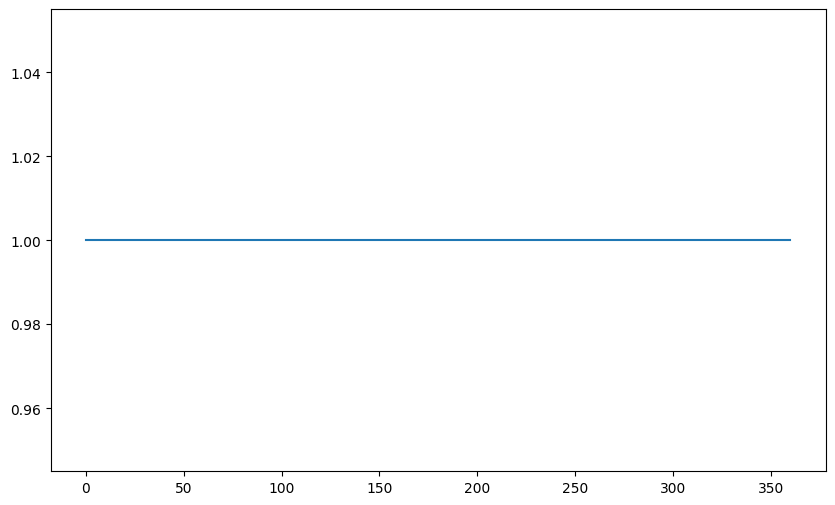

In [94]:
Z = sinusoid_from_angles(theta_grid, azimuth, inclination, R=8.5) #I need to go back to the pixel space 
plt.figure(figsize=(10, 6))
plt.plot(np.rad2deg(theta_grid), Z, label=f'Incl: {inclination_idx}°, Azim: {azimuth_idx}, max:{i}')
plt.show()

We see that the second mehtod does not retreive the sinusoids correctly, maybe it is due to an error in the implementation or to a deeper rooted problem.